In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def show_maze(maze, path=None):
    if path is None:
        path = np.copy(maze)
        path.fill(False)

    path_masked = np.ma.masked_array(path, maze)
    maze_masked = np.ma.masked_array(maze, path)

    fig, ax = plt.subplots()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(path_masked, cmap='Reds', vmin=0, vmax=1)
    ax.imshow(maze_masked, cmap='binary', vmin=0, vmax=1)
    plt.show()

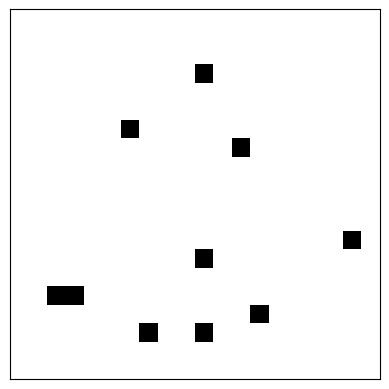

In [4]:
data = np.loadtxt("data/maze_1.csv", delimiter=",", dtype=bool)
n = len(data)
show_maze(data)

In [5]:
def get_way_to_exit(maze):
    end = len(maze) - 1
    reacheable = []
    previous_step_info = [((0,0), (0, 0))]   # has information about each points' predecessor
    previous_step = [(0, 0)]    # all visited points
    steps = []

    while True:
        steps.append(previous_step_info)
        tmp_info = []
        tmp = []

        for point in previous_step:
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]   # directions in which we can go to from this particular point
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])

                if not maze[p[0], p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp_info.append(tuple([point, p]))
                    tmp.append(p)

                if p == (end, end):   # we found exit
                    steps.append(tmp_info)
                    return steps
                
        if(len(tmp) == 0):   # we've been to all points reachable from (0, 0)
           return steps
        
        previous_step_info = tmp_info
        previous_step = tmp

In [6]:
def get_path(steps):
    i = len(steps) - 1
    path = [(len(data) - 1, len(data) - 1)]   # we assume that there's way to exit from (0, 0)
    while ((0, 0), (0, 0)) not in steps[i]:
        for info in steps[i]:
            if path[-1] in info:
                path.append(info[0])
                i -= 1
                break
    return path

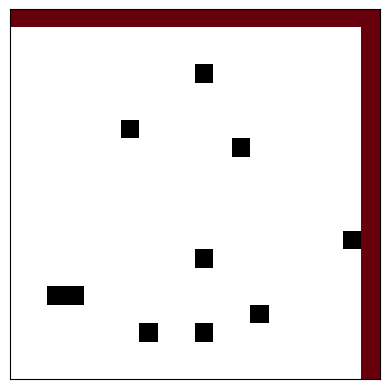

In [7]:
steps = get_way_to_exit(data)
path = get_path(steps)
path_maze = np.ndarray(shape=[len(data), len(data)], dtype=bool)
path_maze.fill(False)
for point in path:
    path_maze[point[0], point[1]] = True

show_maze(data, path_maze)

prochazime bludiste a hrany grafu postupne pridavame do incidenční matice

In [8]:
def genarate_incidence(maze):   # returns incindence matrix for connected graf, which contains (0, 0)
    incidence = [np.array([False for i in range(n**2)])]
    end = len(maze) - 1
    reacheable = []
    previous_step_info = [((0, 0), (0, 0))]
    previous_step = [(0, 0)]
    steps = []

    while True:
        steps.append(previous_step_info)
        tmp_info = []
        tmp = []

        for point in previous_step:
            reacheable.append(point)
            where = [(-1, 0), (0, 1), (0, -1), (1, 0)]
            if point[0] == 0:
                where.remove((-1, 0))
            if point[1] == 0:
                where.remove((0, -1))
            if point[0] == end:
                where.remove((1, 0))
            if point[1] == end:
                where.remove((0, 1))

            for to in where:
                p = (point[0] + to[0], point[1] + to[1])

                if not maze[p[0], p[1]] and not (p in reacheable or p in previous_step or p in tmp):
                    tmp_info.append(tuple([point, p]))
                    tmp.append(p)

                    edge = [np.array([False for i in range(n**2)])]
                    edge[0][p[0] * n + p[1]] = True
                    edge[0][(point[0]) * n + point[1]] = True
                    incidence = np.append(incidence, edge, axis=0)


                if p == (end, end):
                    steps.append(tmp_info)
                                    
        if(len(tmp) == 0):
            incidence = np.delete(incidence, 0, axis=0)
            return incidence
        
        previous_step_info = tmp_info
        previous_step = tmp

In [9]:
def generate_maze(incidence):
    n = int(len(incidence[0])**0.5)
    maze = np.ndarray(shape=[n, n], dtype=bool)
    maze.fill(True)
    for edge in incidence:
        id = np.where(edge == True)[0]
        for i in id:
            x = i // n
            y = i % n
            maze[x, y] = False
    return maze

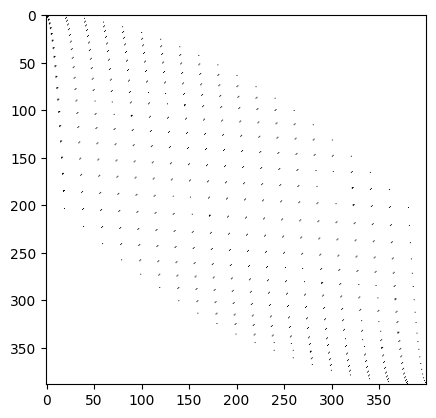

In [10]:
incidence = genarate_incidence(data)
#print(incidence[:, 1], np.where(incidence[:, 1] == True))
#print(incidence)
fig, ax = plt.subplots()
ax.imshow(incidence, cmap='binary')
plt.show()

In [11]:
def dijkstra(incidence):
    end = len(incidence[0]) - 1
    visited_nodes = np.array([0], dtype=int)   # nodes we've already been to
    edges = np.where(incidence[:, 0])[0]   # edges we're visiting this step
    while True:
        tmp_edges = np.array([], dtype=int)   # edges we'll visit in next step
        for edge in edges:
            nodes_tmp = np.where(incidence[edge])[0]   # nodes we can go to from this edge
            nodes_tmp = nodes_tmp[np.where(np.isin(nodes_tmp, visited_nodes) == False)[0]]   # nodes we can to from this edge, but without visited (len(nodes_tmp) == 1)
            edges_tmp = np.where(incidence[:, nodes_tmp])[0]   # edges, leading to new nodes
            tmp_edges = np.append(tmp_edges, edges_tmp)
            visited_nodes = np.append(visited_nodes, nodes_tmp)
            if end in nodes_tmp:
                return visited_nodes
        edges = tmp_edges[:]

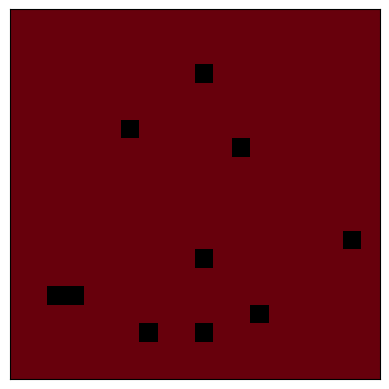

In [12]:
m = dijkstra(incidence)
d = np.ndarray(shape=[int((m[-1] + 1)**0.5), int((m[-1] + 1)**0.5)], dtype=bool)
d.fill(False)
for node in m:
    x = node // n
    y = node % n
    d[x, y] = True
show_maze(data, d)

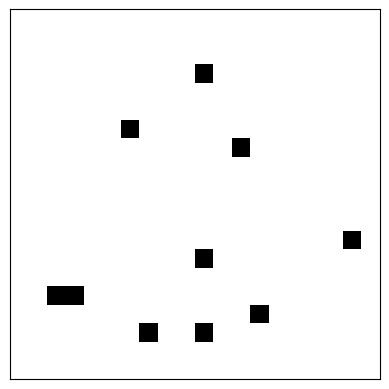

In [13]:
m = generate_maze(incidence)
show_maze(m)

In [14]:
def dijkstra_extended(incidence):
    nodes_inf = np.array([(-1, 0)], dtype=tuple)   # -1 - edgde, 0 - node
    end = len(incidence[0]) - 1
    visited_nodes = np.array([0], dtype=int)   # nodes we've already been to
    edges = np.where(incidence[:, 0])[0]   # edges we're visiting this step
    while True:
        tmp_edges = np.array([], dtype=int)   # edges we'll visit in next step
        for edge in edges:
            nodes_tmp = np.where(incidence[edge])[0]   # nodes we can go to from this edge
            nodes_tmp = nodes_tmp[np.where(np.isin(nodes_tmp, visited_nodes) == False)[0]]   # nodes we can to from this edge, but without visited
            if(len(nodes_tmp)):
                nodes_inf = np.append(nodes_inf, [(edge, nodes_tmp[0])], axis=0)
            if end in nodes_tmp:
                return nodes_inf
            edges_tmp = np.where(incidence[:, nodes_tmp])[0]   # edges, leading to new nodes
            tmp_edges = np.append(tmp_edges, edges_tmp)
            visited_nodes = np.append(visited_nodes, nodes_tmp)
        edges = tmp_edges[:]

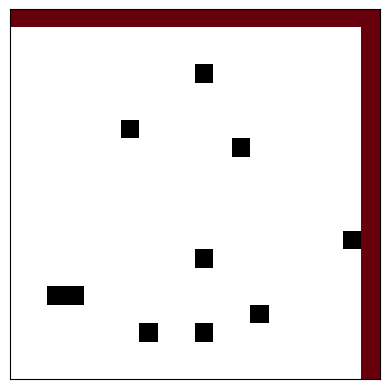

In [16]:
n_inf = dijkstra_extended(incidence)
n = int((len(incidence[0]) + 1)**0.5)
res = np.ndarray(shape=[n, n], dtype=bool)
res.fill(False)
step = n_inf[np.where(n_inf[:, 1] == len(incidence[0]) - 1)][0]
while step[0] != -1:
    node = step[1]
    x = node // n
    y = node % n
    res[x, y] = True
    nodes = np.where(incidence[step[0]])[0]   # current edge connects this nodes
    next_node = nodes[np.where(nodes != node)]   # we choose another node
    step = n_inf[np.where(n_inf[:, 1] == next_node)][0]
res[0, 0] = True
show_maze(data, res)

